# COVID-19 Tweets Sentiment Predict

## 0. Project descripe



#### **Data source:**https://www.kaggle.com/datasets/bansodesandeep/covid19-tweets-data

### Problem Statement:
* In this project, We will predict the sentiment of these tweets about COVID-19. COVID-19 has made everyone panic in recent years, and some people are expressing their sentiment on social media. If we can distinguish the sentiment of words, we can better care for people who are panicking.

### About Data:
* 41157 Rows
* 6 columns
1. UserName (The User ID who tweet)
2. ScreenName (The tweet UUID)
3. Location 
4. TweetAt (Time)
5. OriginalTweet 
6. Sentiment

## 1. Import libraries

In [44]:
# import libraries
import numpy as np
import pandas as pd
import random
import os

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# text work
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.layers import Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping

## 2. EDA

### 2.1 Import Data

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid19-tweets-data/Corona_NLP_train.csv


In [5]:
df = pd.read_csv('/kaggle/input/covid19-tweets-data/Corona_NLP_train.csv', encoding='latin-1')

### 2.2 Observed the data

In [7]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [9]:
df.shape

(41157, 6)

<AxesSubplot:ylabel='Sentiment'>

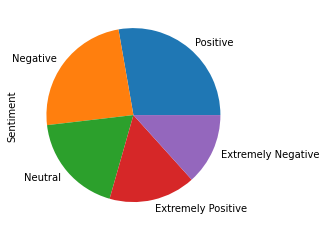

In [10]:
df['Sentiment'].value_counts().plot(kind='pie')

In [13]:
df.isnull().sum()

UserName            0
ScreenName          0
Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64

##### There are 8590 null in Location Column

### 2.3 Clean the data

#### 2.3.1 Drop the useless feature
I will distinguish the sentiment by `OriginalTweet`.

In [15]:
df = df.drop('Location', axis=1)
df = df.drop('UserName', axis=1)
df = df.drop('ScreenName', axis=1)
df = df.drop('TweetAt', axis=1)

In [16]:
df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


#### delete the Neutral rows

In [206]:
df = df[df.Sentiment != 'Neutral']

In [207]:
df.head()

,OriginalTweet,Sentiment,NewTweet
1,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...
3,My food stock is not the only one which is emp...,Positive,food stock one empti pleas panic enough food e...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,readi go supermarket covid outbreak paranoid f...
5,As news of the regionÂs first confirmed COVID...,Positive,news region first confirm covid case came sull...


#### 2.3.2 Clean the tweets

Build a help function to process text

I will remove URL, HTML tags, emotes, symbols, flags, stopwords, and make all text lowercase.

In [208]:
ps = PorterStemmer()
def process_text(data):
    review = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',data) # remove URL
    review = re.sub(r'<.*>',' ',review) # remove HTML tags
    review = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',review)
    review = re.sub('[^a-zA-Z]',' ',review) # filtering out miscellaneous text.
    review = review.lower()
    review = review.split()
    review = [ps.stem(words) for words in review if words not in stopwords.words('english') and words.isalpha()]
    review = ' '.join(review)
    return review

In [26]:
df['NewTweet'] = df['OriginalTweet'].apply(process_text)

In [209]:
df.head()

,OriginalTweet,Sentiment,NewTweet
1,advice Talk to your neighbours family to excha...,Positive,advic talk neighbour famili exchang phone numb...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronaviru australia woolworth give elderli di...
3,My food stock is not the only one which is emp...,Positive,food stock one empti pleas panic enough food e...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,readi go supermarket covid outbreak paranoid f...
5,As news of the regionÂs first confirmed COVID...,Positive,news region first confirm covid case came sull...


And split to X and y

In [210]:
X = df['NewTweet']
y = df['Sentiment']

### 2.3.3 split train valid and test data

Data plan

     train        valid    test              
|--------50%--------|--16.6%--|---- 33%----|

In [211]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, 
    y, 
    test_size=0.33, 
    random_state=777)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, 
    y_train_valid, 
    test_size=0.25, 
    random_state=777)

In [212]:
print('X_train:',X_train.shape)
print('X_valid:',X_valid.shape)
print('X_test:',X_test.shape)
print('y_train:',y_train.shape)
print('y_valid:',y_valid.shape)
print('y_test:',y_test.shape)

X_train: (16805,)
X_valid: (5602,)
X_test: (11037,)
y_train: (16805,)
y_valid: (5602,)
y_test: (11037,)


### 2.3.4 token the text

Build a help function to token the text

In [213]:

tokenizer = Tokenizer(num_words=2500, split=' ')
tokenizer.fit_on_texts(df['NewTweet'].values)
def token_the_text(text):
    token = tokenizer.texts_to_sequences(text.values)
    token = pad_sequences(token)
    return token

In [214]:
X_train_token = token_the_text(X_train)
X_valid_token = token_the_text(X_valid)
X_test_token = token_the_text(X_test)

Difference between token and original text

In [215]:
print(X_train_token[0])
print(X_train.values[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0   42   75 1380  110  182  256  162  113    3  443
  314  944  403   51    1    2   18]
stay safe indoor famili medic deliv offer low price top brand name gener product youdrugstor onlinepharmaci canadianpharmaci covid coronaviru pandem


## 3.Build the Model

### 3.1 simple LSTM 

In [216]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In this case, i will choose `sigmoid` for my output activation function.
Because I just delete the `Neutral` rows, and I will set `Extremely Positive` and `Positive` to `1`
`Extremely Negative` and `Negative` to `0`

In [220]:

with strategy.scope():
    model_LSTM = Sequential()
    model_LSTM.add(Embedding(2500, 150, input_length = 50))
    model_LSTM.add(Bidirectional(LSTM(128)))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(256, activation='relu'))
    model_LSTM.add(Dropout(0.2))
    model_LSTM.add(Dense(1, activation='sigmoid'))


    model_LSTM.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
    model_LSTM.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 50, 150)           375000    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 256)               285696    
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_33 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 257       
Total params: 726,745
Trainable params: 726,745
Non-trainable params: 0
_______________________________________________

Build a help function to convert label to `0` and `1`

In [217]:
def convert(text):
    if text == 'Extremely Negative' or text == 'Negative':
        return 0
    elif text == 'Extremely Positive' or text == 'Positive':
        return 1
    else:
        return text

In [218]:
y_train = y_train.apply(convert)
y_valid = y_valid.apply(convert)
y_test = y_test.apply(convert)

Fit the model with training data

In [221]:
LSTM_h = model_LSTM.fit(X_train_token, 
                      y_train.values, 
                      epochs=10,
                      verbose=1,
                      batch_size=64,
                      validation_data=(X_valid_token, y_valid.values),
                      validation_freq = 1)

Epoch 1/10
263/263 [==============================] - 33s 111ms/step - loss: 0.4723 - accuracy: 0.7645 - val_loss: 0.3768 - val_accuracy: 0.8409
Epoch 2/10
263/263 [==============================] - 28s 105ms/step - loss: 0.3214 - accuracy: 0.8680 - val_loss: 0.3675 - val_accuracy: 0.8472
Epoch 3/10
263/263 [==============================] - 27s 103ms/step - loss: 0.2756 - accuracy: 0.8913 - val_loss: 0.3841 - val_accuracy: 0.8445
Epoch 4/10
263/263 [==============================] - 28s 105ms/step - loss: 0.2407 - accuracy: 0.9042 - val_loss: 0.4119 - val_accuracy: 0.8402
Epoch 5/10
263/263 [==============================] - 27s 104ms/step - loss: 0.1949 - accuracy: 0.9263 - val_loss: 0.4875 - val_accuracy: 0.8308
Epoch 6/10
263/263 [==============================] - 28s 105ms/step - loss: 0.1653 - accuracy: 0.9364 - val_loss: 0.5048 - val_accuracy: 0.8318
Epoch 7/10
263/263 [==============================] - 28s 105ms/step - loss: 0.1317 - accuracy: 0.9461 - val_loss: 0.6364 - val_ac

See the trianing history

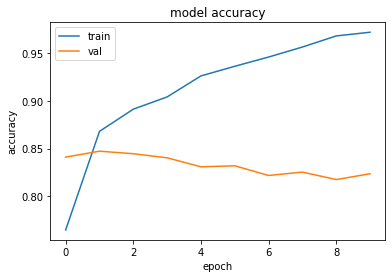

In [222]:

plt.plot(LSTM_h.history['accuracy'])
plt.plot(LSTM_h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Predict the test data

In [225]:
score_LSTM = model_LSTM.evaluate(X_test_token, y_test, batch_size=128)

87/87 [==============================] - 5s 43ms/step - loss: 0.9124 - accuracy: 0.8269


In [239]:
print("model_LSTM loss:",score_LSTM[0])
print("model_LSTM accuracy:",score_LSTM[1])

model_LSTM loss: 0.912387490272522
model_LSTM accuracy: 0.8269457221031189


### 3.2 GRU

In [241]:

with strategy.scope():
    model_GRU = Sequential()
    model_GRU.add(Embedding(2500, 200, input_length = 50))
    model_GRU.add(Bidirectional(GRU(128)))
    model_GRU.add(Dropout(0.2))
    model_GRU.add(Dense(256, activation='relu'))
    model_GRU.add(Dropout(0.2))
    model_GRU.add(Dense(1, activation='sigmoid'))


    model_GRU.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
    model_GRU.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 50, 200)           500000    
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 256)               253440    
_________________________________________________________________
dropout_44 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_45 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 257       
Total params: 819,489
Trainable params: 819,489
Non-trainable params: 0
_______________________________________________

In [242]:
GRU_h = model_GRU.fit(X_train_token, 
                      y_train.values, 
                      epochs=10,
                      verbose=1,
                      batch_size=64,
                      validation_data=(X_valid_token, y_valid.values),
                      validation_freq = 1)

Epoch 1/10
263/263 [==============================] - 74s 118ms/step - loss: 0.4740 - accuracy: 0.7636 - val_loss: 0.4028 - val_accuracy: 0.8188
Epoch 2/10
263/263 [==============================] - 30s 116ms/step - loss: 0.3175 - accuracy: 0.8703 - val_loss: 0.3634 - val_accuracy: 0.8474
Epoch 3/10
263/263 [==============================] - 31s 117ms/step - loss: 0.2721 - accuracy: 0.8924 - val_loss: 0.3672 - val_accuracy: 0.8433
Epoch 4/10
263/263 [==============================] - 30s 113ms/step - loss: 0.2309 - accuracy: 0.9118 - val_loss: 0.4124 - val_accuracy: 0.8438
Epoch 5/10
263/263 [==============================] - 29s 112ms/step - loss: 0.1926 - accuracy: 0.9272 - val_loss: 0.4458 - val_accuracy: 0.8338
Epoch 6/10
263/263 [==============================] - 30s 114ms/step - loss: 0.1523 - accuracy: 0.9436 - val_loss: 0.5430 - val_accuracy: 0.8336
Epoch 7/10
263/263 [==============================] - 31s 117ms/step - loss: 0.1254 - accuracy: 0.9529 - val_loss: 0.6199 - val_ac

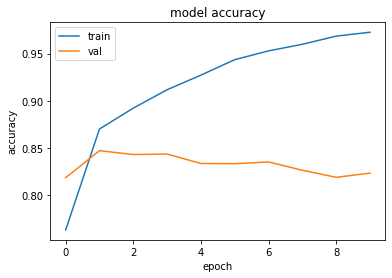

In [243]:

plt.plot(GRU_h.history['accuracy'])
plt.plot(GRU_h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [244]:
score_GRU = model_GRU.evaluate(X_test_token, y_test, batch_size=128)

87/87 [==============================] - 5s 47ms/step - loss: 0.7879 - accuracy: 0.8225


In [246]:
print("model_GRU  loss:",score_GRU[0])
print("model_GRU  accuracy:",score_GRU[1])

model_GRU  loss: 0.7878970503807068
model_GRU  accuracy: 0.8225061297416687


## 4.Result

Compare two models performace

||  LSTM   | GRU  |
|  ----  |  ----  | ----  |
|loss| 0.912387  | 0.787897 |
|accuracy| 0.826945  | 0.822506 |

The 2 models have almost the same accuracy are almost same accuracy.
The accuracy of both models is greater than 0.8, that is a nice result

### Conclusion

In this project, I used `LSTM` and `GRU` to classify sentiment of these tweets.In EDA, I dropped the useless feature and cleaned the text for our models. Second step is to tokenize these cleaned tweets, after tokenizing, the text will convert to a word index, it makes the training model more simple. After EDA, we built 2 models `LSTM` and `GRU` ,two models almost have the same structure, only the Bidirectional layer is different.The models performed well after training ,and if models can be trained with a larger amount of data, the accuracy of the classification will be better.